In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                        poly,
                        ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam,
                    l as l_gam,
                    f as f_gam,
                    LinearGAM,
                    LogisticGAM)
from ISLP.transforms import (BSpline,
                            NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

# Polynomial Regression and Step Functions

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
# Use poly() (from ISLP.models) function to create 
# model matrix that fit 4th degree polynomial in age

poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [5]:
# Grid of values for age
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

In [6]:
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray', alpha=0.5)

    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b', 'r--', 'r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

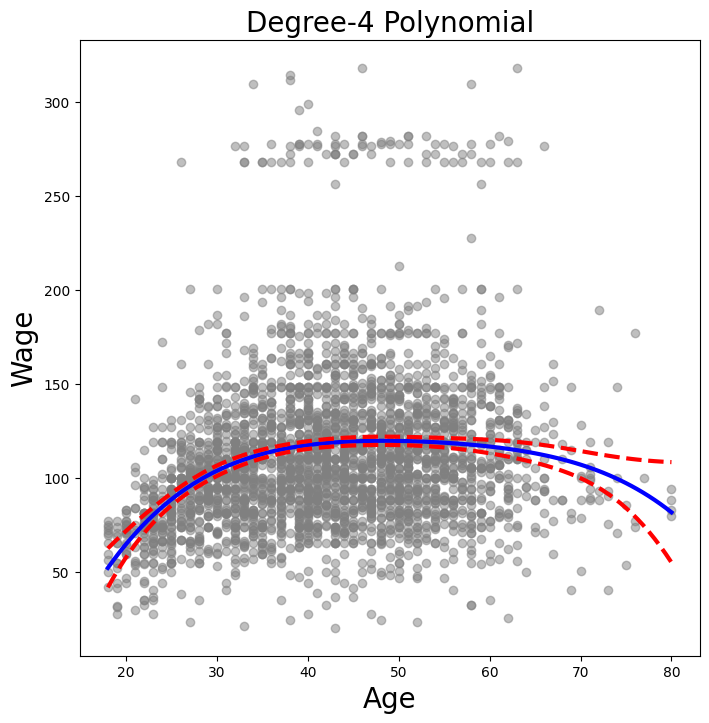

In [7]:
# Plot the fit of the 4th degree polynomial
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

# Analysis of Variance (ANOVA tests)

Tests the null hypotheses that a model M1 is sufficient to explain the data agains the alternative hypotheses that a more complex model M2 is required.

The determination is based on an **F-test**.

Fit five different polynomial models and sequentially compare the simpler model to the more complex model.

In [8]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


p-value comparing `models[0]` (linear) with `models[1]` (quadratic) is practically zero. This indicates that a linear fit is not enough.

p-value comparing `models[1]` (quadratic) with `models[2]` (cubic) is 0.0017 (close to zero). This indicates that a quadratic fit is not enough.

p-value comparing `models[2]` (cubic) with `models[3]` (degree 4) is 0.05 (5%).

p-value comparing `models[3]` (degree 4) with `models[4]` (degree 5) is 0.37 (37%). This indicates that a degree 5 polynomial seems unnecesary.

In conclusion, *a cubic or a quartic polynomial appear to provide a reasonable fit to the data*.

In [9]:
# Obtain same p-values in another way
# poly() creates orthogonal polynomials

summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [ ]:
# The square of the t-statistics are equal to the F-statistics from the anova_lm() function